# Projet 2

## I. ML Based Recommmendation

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords, movie_reviews
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Load Dataset
data = pd.read_csv("filtered_tmdb_data.csv")
data.head()

,imdb_id,title,release_date,genres,runtime,vote_average,overview,region,primaryName,primaryProfession
0,tt0109830,Forrest Gump,1994-06-23,"['Comedy', 'Drama', 'Romance']",142,8.481,A man with a low IQ has accomplished great thi...,FR,Tom Hanks,"producer,actor,writer"
1,tt0109830,Forrest Gump,1994-06-23,"['Comedy', 'Drama', 'Romance']",142,8.481,A man with a low IQ has accomplished great thi...,FR,Robin Wright,"actress,producer,director"
2,tt0109830,Forrest Gump,1994-06-23,"['Comedy', 'Drama', 'Romance']",142,8.481,A man with a low IQ has accomplished great thi...,US,Tom Hanks,"producer,actor,writer"
3,tt0109830,Forrest Gump,1994-06-23,"['Comedy', 'Drama', 'Romance']",142,8.481,A man with a low IQ has accomplished great thi...,US,Robin Wright,"actress,producer,director"
4,tt0078788,Apocalypse Now,1979-08-15,"['Drama', 'War']",147,8.281,"At the height of the Vietnam war, Captain Benj...",US,Martin Sheen,"actor,producer,director"


In [ ]:
# Create DataFrame
df = pd.DataFrame(data)

# Group by imdb_id and title, and extract the first two primary names and regions
df = (
    df.groupby(['imdb_id', 'title'])
    .agg({
        'release_date': 'first',
        'genres': 'first',
        'runtime': 'first',
        'vote_average': 'first',
        'overview': 'first',
        'region': 'first',
        'primaryName': lambda x: list(x)[:2],  # Get first two primaryName
    })
    .reset_index()
)

# Separate Primary Actor and Secondary Actor
df['Primary Actor'] = df['primaryName'].apply(lambda x: x[0] if len(x) > 0 else None)
df['Secondary Actor'] = df['primaryName'].apply(lambda x: x[1] if len(x) > 1 else None)

# Drop the intermediate 'primaryName' and 'region' columns
df = df.drop(columns=['primaryName'])

# Final DataFrame
df.head()

,imdb_id,title,release_date,genres,runtime,vote_average,overview,region,Primary Actor,Secondary Actor
0,tt0070269,The Kill,1975-09-02,"['Action', 'Drama', 'Crime']",81,6.000,"Set in Macao, the film finds Richard Jaeckel c...",US,Richard Jaeckel,Henry Duval
1,tt0071093,Abigail Leslie Is Back in Town,1975-09-01,['Drama'],96,6.200,Abigail Leslie has been away for years but has...,US,Mary Mendum,Jennifer Jordan
2,tt0071118,All Creatures Great and Small,1975-07-27,"['Drama', 'TV Movie']",92,6.400,"James Herriot is a vet in Yorkshire, England, ...",US,Brenda Bruce,Christine Buckley
3,tt0071169,Au-delà de la peur,1975-09-23,"['Thriller', 'Drama']",92,6.500,French movie,FR,Michel Bouquet,Michel Constantin
4,tt0071449,The Common Man,1975-02-26,"['Drama', 'Thriller']",90,6.895,"As every summer, Georges Lajoie, his wife Gine...",US,Jean Carmet,Pierre Tornade


In [ ]:
# Summarize the data in the file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3415 entries, 0 to 3414
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   imdb_id          3415 non-null   object 
 1   title            3415 non-null   object 
 2   release_date     3415 non-null   object 
 3   genres           3415 non-null   object 
 4   runtime          3415 non-null   int64  
 5   vote_average     3415 non-null   float64
 6   overview         3415 non-null   object 
 7   region           3415 non-null   object 
 8   Primary Actor    3415 non-null   object 
 9   Secondary Actor  3347 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 266.9+ KB


In [ ]:
# Count the number of missing values in each column of the DataFrame
df.isnull().sum()

,0
imdb_id,0
title,0
release_date,0
genres,0
runtime,0
vote_average,0
overview,0
region,0
Primary Actor,0
Secondary Actor,68


In [ ]:
# Count the occurrences of each unique value in the "genres" column
df["genres"].value_counts()

,count
genres,
['Drama'],501
['Comedy'],254
"['Drama', 'TV Movie']",199
"['Drama', 'Romance']",144
"['Comedy', 'Drama']",131
...,...
"['Romance', 'Comedy', 'Drama', 'Fantasy']",1
"['Action', 'Drama', 'History']",1
"['Music', 'Comedy', 'Drama', 'Romance']",1


In [ ]:
# Filter the DataFrame to exclude rows where the "genres" column contains "TV Movie"
df = df[df["genres"].str.contains("TV Movie") == False]
df.head()

,imdb_id,title,release_date,genres,runtime,vote_average,overview,region,Primary Actor,Secondary Actor
0,tt0070269,The Kill,1975-09-02,"['Action', 'Drama', 'Crime']",81,6.000,"Set in Macao, the film finds Richard Jaeckel c...",US,Richard Jaeckel,Henry Duval
1,tt0071093,Abigail Leslie Is Back in Town,1975-09-01,['Drama'],96,6.200,Abigail Leslie has been away for years but has...,US,Mary Mendum,Jennifer Jordan
3,tt0071169,Au-delà de la peur,1975-09-23,"['Thriller', 'Drama']",92,6.500,French movie,FR,Michel Bouquet,Michel Constantin
4,tt0071449,The Common Man,1975-02-26,"['Drama', 'Thriller']",90,6.895,"As every summer, Georges Lajoie, his wife Gine...",US,Jean Carmet,Pierre Tornade
5,tt0071533,The Mob,1975-02-27,"['Crime', 'Drama']",86,7.000,Seasoned drug smuggler and thief François “Chi...,US,Marc Legault,Dorothée Berryman


In [ ]:
# Summarize the data in the file
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2813 entries, 0 to 3414
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   imdb_id          2813 non-null   object 
 1   title            2813 non-null   object 
 2   release_date     2813 non-null   object 
 3   genres           2813 non-null   object 
 4   runtime          2813 non-null   int64  
 5   vote_average     2813 non-null   float64
 6   overview         2813 non-null   object 
 7   region           2813 non-null   object 
 8   Primary Actor    2813 non-null   object 
 9   Secondary Actor  2756 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 306.3+ KB


<Axes: >

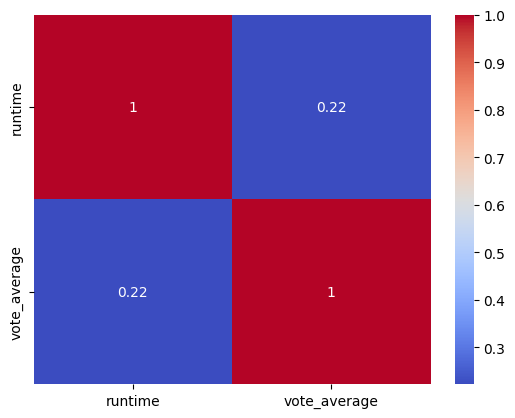

In [ ]:
# Create a heatmap of the correlation matrix
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')

In [ ]:
# Define a dictionary to map month names to their corresponding numerical order
month_order = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}

# Extract the year from the 'release_date' column and create a new 'year' column
df['year'] =  pd.to_datetime(df['release_date']).dt.year

# Extract the month name from the 'release_date' column and create a new 'month' column
df['month'] = pd.to_datetime(df['release_date']).dt.month_name()

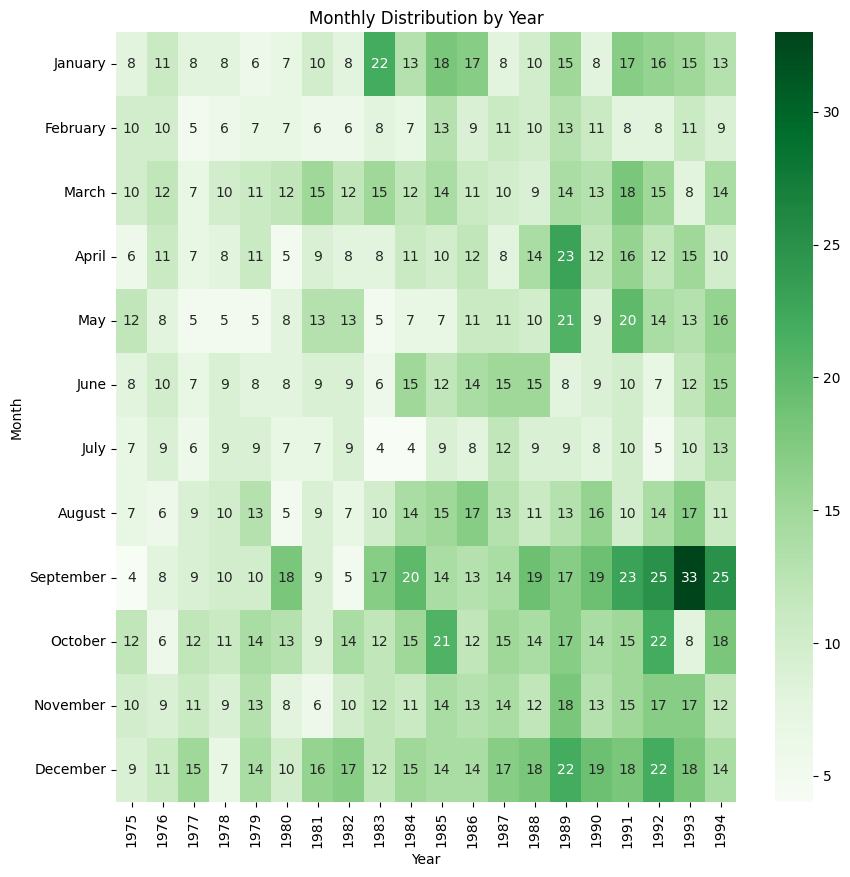

In [ ]:
# Create month order as a list
month_order_list = list(month_order.keys())

# Group by 'year' and count occurrences of each 'month', then reorder columns
df_heatmap = (
    df.groupby('year')['month']
    .value_counts()
    .unstack(fill_value=0)
    .reindex(columns=month_order_list)
    .T  # Transpose for the heatmap
)

# Plot the heatmap
plt.subplots(figsize=(10, 10))
sns.heatmap(df_heatmap, cmap='Greens', annot=True, fmt='g')
plt.title('Monthly Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

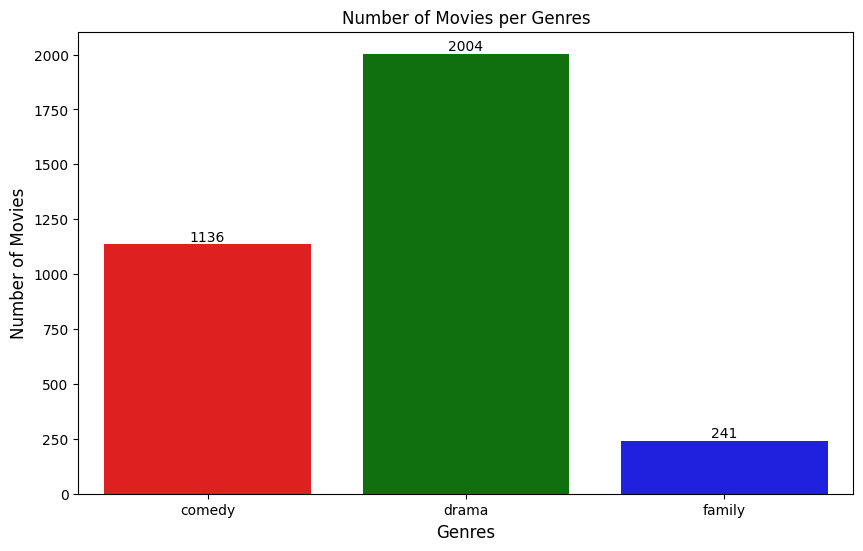

In [ ]:
# Data manipulation (replace with your actual data manipulation)
num_movies = [len(df[df['genres'].astype(str).str.contains("comedy", case=False)]),
              len(df[df['genres'].astype(str).str.contains("drama", case=False)]),
              len(df[df['genres'].astype(str).str.contains("family", case=False)])]

genres = ["comedy", "drama", "family"]
df_genres = pd.DataFrame({'Number of Movies': num_movies, 'Genres': genres})

# Plotting
plt.figure(figsize=(10, 6))
sns.set_palette("pastel")  # Use a color palette
ax = sns.barplot(x='Genres', y='Number of Movies', data=df_genres, palette=['red', 'green', 'blue'])  # Specify colors for each bar

# Adding values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Number of Movies per Genres')
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)

plt.show()

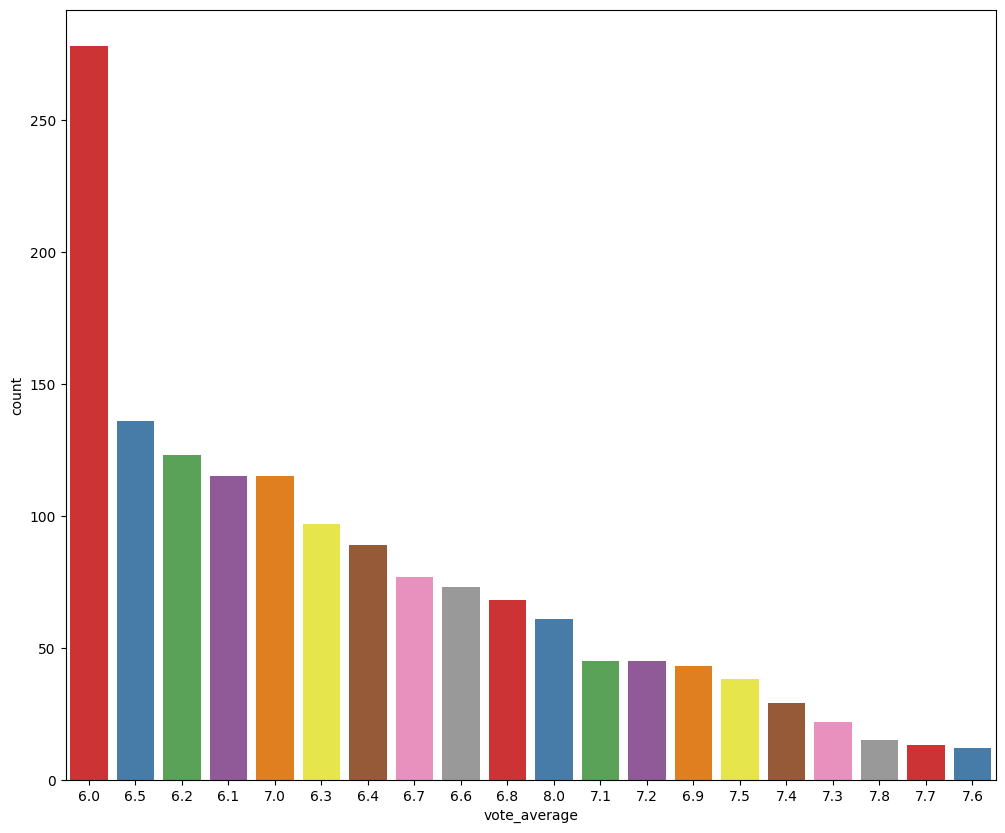

In [ ]:
# Create a countplot of 'vote_average' using seaborn
plt.figure(figsize=(12,10))
ax = sns.countplot(x="vote_average", data=df,palette="Set1",order=df['vote_average'].value_counts().index[0:20])

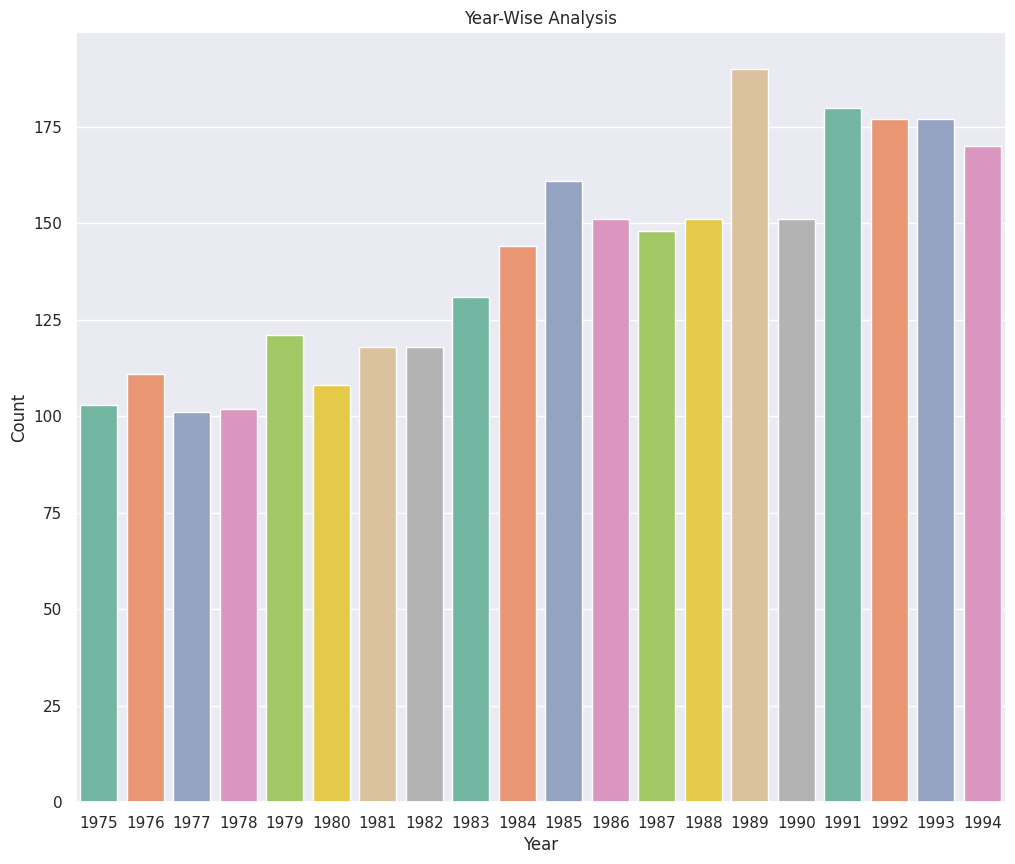

In [ ]:
# Create a DataFrame from the year counts
year_counts = df['year'].value_counts().reset_index()
year_counts.columns = ['year', 'count']

# Sort the DataFrame by year (optional, for chronological order)
year_counts = year_counts.sort_values(by='year')

# Plot the data using seaborn
plt.figure(figsize=(12, 10))
sns.set(style="darkgrid")
ax = sns.barplot(
    y="count",
    x="year",
    data=year_counts,
    palette="Set2",
    order=year_counts['year'][:20]
)

# Set labels and title
ax.set_title("Year-Wise Analysis")
ax.set_xlabel("Year")
ax.set_ylabel("Count")
plt.show()

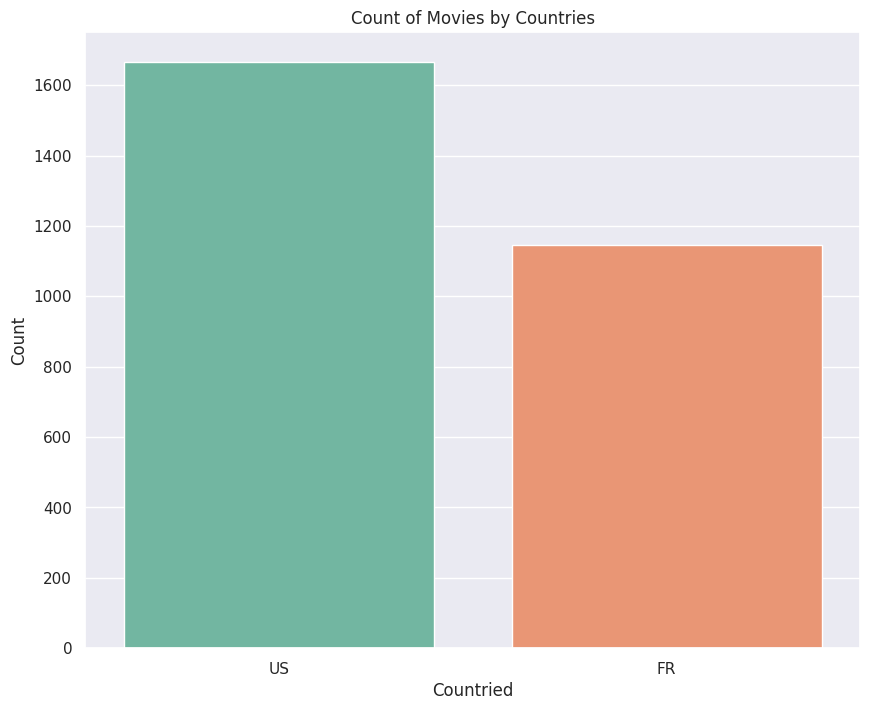

In [ ]:
# Create a DataFrame for region counts
country_counts = df["region"].value_counts().reset_index()
country_counts.columns = ["region", "count"]

# Plot the bar chart
plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x="region",
    y="count",
    data=country_counts ,
    palette="Set2"
)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Set labels and title
ax.set_title("Count of Movies by Countries")
ax.set_xlabel("Countried")
ax.set_ylabel("Count")
plt.show()

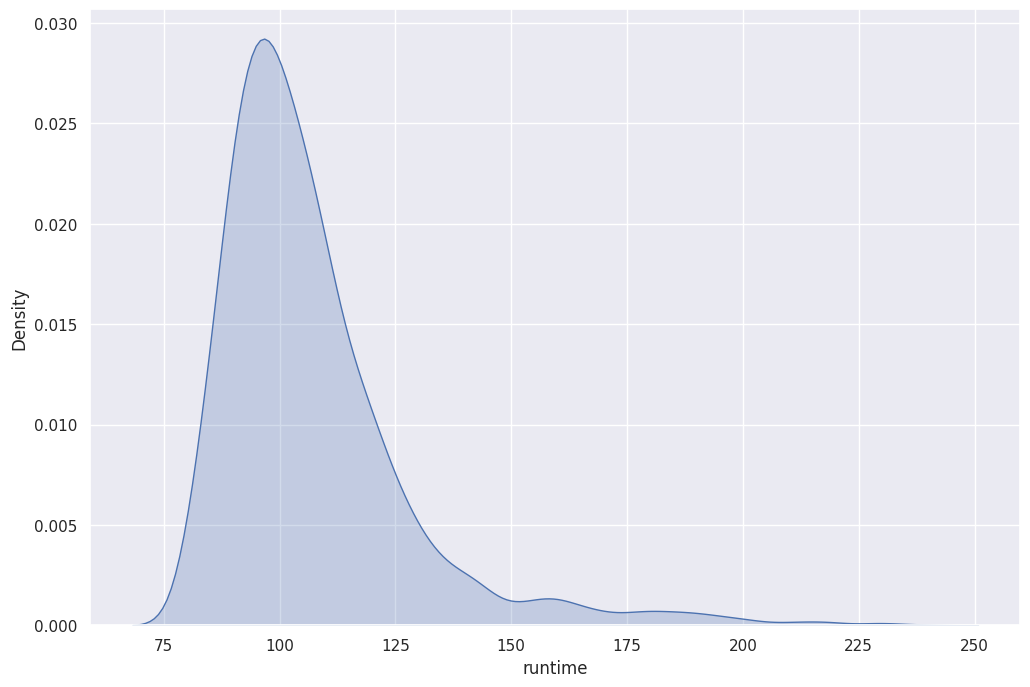

In [ ]:
# Create a kernel density plot of 'runtime'
sns.set(style="darkgrid")
plt.figure(figsize=(12,8))
ax=sns.kdeplot(data=df['runtime'], shade=True)

In [ ]:
# Factorize the 'original_language' column and create a new column 'original_language_encoded'
df['region_encoded'] = df['region'].factorize()[0]
df.head()

,imdb_id,title,release_date,genres,runtime,vote_average,overview,region,Primary Actor,Secondary Actor,year,month,region_encoded
0,tt0070269,The Kill,1975-09-02,"['Action', 'Drama', 'Crime']",81,6.000,"Set in Macao, the film finds Richard Jaeckel c...",US,Richard Jaeckel,Henry Duval,1975,September,0
1,tt0071093,Abigail Leslie Is Back in Town,1975-09-01,['Drama'],96,6.200,Abigail Leslie has been away for years but has...,US,Mary Mendum,Jennifer Jordan,1975,September,0
3,tt0071169,Au-delà de la peur,1975-09-23,"['Thriller', 'Drama']",92,6.500,French movie,FR,Michel Bouquet,Michel Constantin,1975,September,1
4,tt0071449,The Common Man,1975-02-26,"['Drama', 'Thriller']",90,6.895,"As every summer, Georges Lajoie, his wife Gine...",US,Jean Carmet,Pierre Tornade,1975,February,0
5,tt0071533,The Mob,1975-02-27,"['Crime', 'Drama']",86,7.000,Seasoned drug smuggler and thief François “Chi...,US,Marc Legault,Dorothée Berryman,1975,February,0


In [ ]:
# Checks if a given genre is present in a list of genres
def check_genre(genres_list, genre):
  return 1 if genre in genres_list else 0

# Apply the function to create new columns
for genre in ['Family', 'Comedy', 'Drama']:
  df[genre] = df['genres'].apply(lambda x: check_genre(x, genre))

# Print the DataFrame
df.head()

,imdb_id,title,release_date,genres,runtime,vote_average,overview,region,Primary Actor,Secondary Actor,year,month,region_encoded,Family,Comedy,Drama
0,tt0070269,The Kill,1975-09-02,"['Action', 'Drama', 'Crime']",81,6.000,"Set in Macao, the film finds Richard Jaeckel c...",US,Richard Jaeckel,Henry Duval,1975,September,0,0,0,1
1,tt0071093,Abigail Leslie Is Back in Town,1975-09-01,['Drama'],96,6.200,Abigail Leslie has been away for years but has...,US,Mary Mendum,Jennifer Jordan,1975,September,0,0,0,1
3,tt0071169,Au-delà de la peur,1975-09-23,"['Thriller', 'Drama']",92,6.500,French movie,FR,Michel Bouquet,Michel Constantin,1975,September,1,0,0,1
4,tt0071449,The Common Man,1975-02-26,"['Drama', 'Thriller']",90,6.895,"As every summer, Georges Lajoie, his wife Gine...",US,Jean Carmet,Pierre Tornade,1975,February,0,0,0,1
5,tt0071533,The Mob,1975-02-27,"['Crime', 'Drama']",86,7.000,Seasoned drug smuggler and thief François “Chi...,US,Marc Legault,Dorothée Berryman,1975,February,0,0,0,1


In [ ]:
# Sélection des colonnes numériques à normaliser (à adapter selon vos besoins)
numeric_cols = ['runtime', 'vote_average', 'year']  # Exclude categorical columns

# StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df_scaled_minmax = df_scaled.copy()  # df_scaled_minmax now reflects changes in df_scaled

# MinMaxScaler (applied to the already scaled DataFrame)
scaler = MinMaxScaler()
df_scaled_minmax[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# Assign weights to each feature (1-6)
weights = {
    'runtime': 4,
    'vote_average': 5,
    'year': 2,
    'Family': 3,
    'Comedy': 3,
    'Drama': 3
}

# Apply weights to each column
for col, weight in weights.items():
    df_scaled_minmax[col] = df_scaled_minmax[col] * weight

# Extract features and target
y = df['region_encoded']
X = df_scaled_minmax[['runtime', 'vote_average', 'year', 'Family', 'Comedy', 'Drama']]

# Train/Test split and model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
modelknn = KNeighborsClassifier(n_neighbors=5)
modelknn.fit(X_train, y_train)
print("KNN model trained successfully with feature weights.")

KNN model trained successfully with feature weights.


In [ ]:
# Make predictions on the training and testing data
y_train_pred = modelknn.predict(X_train)
y_test_pred = modelknn.predict(X_test)

# Evaluate the model's performance
train_accuracy = modelknn.score(X_train, y_train)
test_accuracy = modelknn.score(X_test, y_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.7013333333333334
Test Accuracy: 0.5914742451154529


In [ ]:
# 'y_test' and 'X_test' are your test data labels and features respectively
cm = confusion_matrix(y_true=y_test, y_pred=modelknn.predict(X_test))

# Create a list of class labels with " ACTUAL" appended
index_labels = [str(cls) + " ACTUAL" for cls in modelknn.classes_]
column_labels = [str(cls) + " PREDICTED" for cls in modelknn.classes_]

# Create the DataFrame with correct labels
cm_df = pd.DataFrame(data=cm, index=index_labels, columns=column_labels)

print(cm_df)

          0 PREDICTED  1 PREDICTED
0 ACTUAL          252          107
1 ACTUAL          123           81


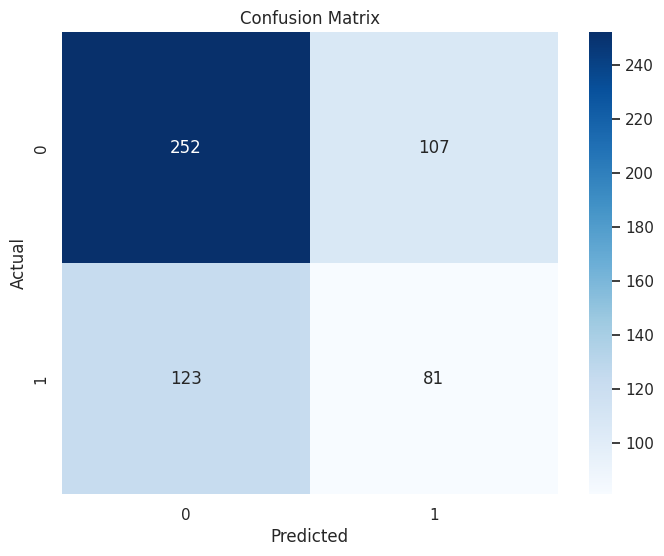

In [ ]:
# Create a DataFrame for the confusion matrix
class_labels = modelknn.classes_  # Assuming modelknn.classes_ returns the class labels
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Input characteristics
input_characteristics = {
    'genres': ['Drama', 'Comedy'],
    'runtime': 120,
    'year': 1990,
    'vote_average': 7.5
}

numeric_cols = ['runtime', 'vote_average', 'year']

# StandardScaler: Normalize numeric columns in the dataset
scaler_standard = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler_standard.fit_transform(df[numeric_cols])

# MinMaxScaler: Further scale numeric columns
scaler_minmax = MinMaxScaler()
df_scaled_minmax = df_scaled.copy()
df_scaled_minmax[numeric_cols] = scaler_minmax.fit_transform(df_scaled[numeric_cols])

# Create a DataFrame row for the input
input_row = {
    'runtime': input_characteristics['runtime'],
    'vote_average': input_characteristics['vote_average'],
    'year': input_characteristics['year']
}

# Add genre columns to the input row
for genre in ['Family', 'Comedy', 'Drama']:
    input_row[genre] = check_genre(input_characteristics['genres'], genre)

# Convert input_row to DataFrame
input_df = pd.DataFrame([input_row])

# Normalize numeric features in the input using both scalers
input_df[numeric_cols] = scaler_standard.transform(input_df[numeric_cols])
input_df[numeric_cols] = scaler_minmax.transform(input_df[numeric_cols])

# Align columns with the training DataFrame
for genre in ['Family', 'Comedy', 'Drama']:
    if genre not in input_df.columns:
        input_df[genre] = 0  # Ensure all expected columns are present

# Convert input_row to DataFrame
input_df = pd.DataFrame([input_row])

# Get nearest neighbors
distances, indices = modelknn.kneighbors(input_df)

# Fetch recommendations
recommendations = df.iloc[indices[0]].copy()

# Print results
print("Recommended Movies:")
for idx, row in recommendations.iterrows():
    print(f"- {row['title']}")

Recommended Movies:
- Mandingo
- Cyrano de Bergerac
- Jeanne Dielman, 23, quai du Commerce, 1080 Bruxelles
- Inside Out
- Walk Proud


In [ ]:
# Define the hyperparameter grid
param_grid = {
    'n_neighbors': range(2, 11),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'cosine']
}

best_score = 0
best_params = {}

# Grid search with nested loops
for n_neighbors in param_grid['n_neighbors']:
    for weights in param_grid['weights']:
        for metric in param_grid['metric']:
            model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            if score > best_score:
                best_score = score
                best_params = {'n_neighbors': n_neighbors, 'weights': weights, 'metric': metric}

print("Best score:", best_score)
print("Best parameters:", best_params)

Best score: 0.6376554174067496
Best parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean'}


In [ ]:
# Assign weights to each feature (1-6)
weights = {
    'runtime': 4,
    'vote_average': 5,
    'year': 2,
    'Family': 3,
    'Comedy': 3,
    'Drama': 3
}

# Apply weights to each column
for col, weight in weights.items():
    df_scaled_minmax[col] = df_scaled_minmax[col] * weight

# Features for similarity
features = ['runtime', 'vote_average', 'year', 'Family', 'Comedy', 'Drama']
X = df_scaled_minmax[features]

# Normalize features for better distance calculations
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensionality using PCA for more efficient model training
pca = PCA(n_components=6)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

# NearestNeighbors Model
modelnn = NearestNeighbors(n_neighbors=10, metric='euclidean')
modelnn.fit(X_pca)
print("NN model trained successfully with feature weights.")

NearestNeighbors(metric='euclidean', n_neighbors=10)

In [ ]:
# Input: Target imdb_id
film_id = "tt0070269"  # Replace this with any valid imdb_id
film_index = df[df['imdb_id'] == film_id].index[0]  # Find the index of the matching imdb_id

# Find nearest neighbors
distances, indices = modelnn.kneighbors([X.iloc[film_index]])

# Display results
print("Selected Movie:")
print(film_id ," - " ,df[df["imdb_id"] == film_id]['title'].values[0])

print("\nMost Similar Movies:")
for idx in indices[0]:
    if idx != film_index:  # Exclude the selected movie itself
        print(f"{df.iloc[idx]['imdb_id']} - {df.iloc[idx]['title']} (Distance: {distances[0][list(indices[0]).index(idx)]:.2f})")

Selected Movie:
tt0070269  -  The Kill

Most Similar Movies:
tt0087004 - The Brother from Another Planet (Distance: 1.97)
tt0091445 - Lucas (Distance: 1.97)
tt0085859 - Local Hero (Distance: 1.98)
tt0090774 - Brighton Beach Memoirs (Distance: 2.00)
tt0085244 - The Big Chill (Distance: 2.00)
tt0090985 - The Decline of the American Empire (Distance: 2.00)
tt0085478 - Educating Rita (Distance: 2.00)
tt0091578 - My Beautiful Laundrette (Distance: 2.01)
tt0093467 - Made in Heaven (Distance: 2.02)
tt0088876 - Came a Hot Friday (Distance: 2.02)


In [ ]:
# Input: Target title
film_title = "The Kill"  # Replace this with any valid movie title
film_index = df[df['title'] == film_title].index[0]  # Find the index of the matching title

# Find nearest neighbors
distances, indices = modelnn.kneighbors([X.iloc[film_index]])

# Display results
print("Selected Movie:")
print(df.loc[df['title'] == film_title, 'imdb_id'].values[0], " - ", film_title)

print("\nMost Similar Movies:")
for idx in indices[0]:
    if idx != film_index:  # Exclude the selected movie itself
        print(f"{df.iloc[idx]['imdb_id']} - {df.iloc[idx]['title']} (Distance: {distances[0][list(indices[0]).index(idx)]:.2f})")

Selected Movie:
tt0070269  -  The Kill

Most Similar Movies:
tt0087004 - The Brother from Another Planet (Distance: 1.97)
tt0091445 - Lucas (Distance: 1.97)
tt0085859 - Local Hero (Distance: 1.98)
tt0090774 - Brighton Beach Memoirs (Distance: 2.00)
tt0085244 - The Big Chill (Distance: 2.00)
tt0090985 - The Decline of the American Empire (Distance: 2.00)
tt0085478 - Educating Rita (Distance: 2.00)
tt0091578 - My Beautiful Laundrette (Distance: 2.01)
tt0093467 - Made in Heaven (Distance: 2.02)
tt0088876 - Came a Hot Friday (Distance: 2.02)


In [ ]:
# Input: Target title to check its caracteristics
def recommend_movies(df, user_movie_title, k_neighbors=10):
    # Check if user-specified movie exists in DataFrame
    if user_movie_title not in df['title'].tolist():
        print(f"Error: Movie '{user_movie_title}' not found in the dataset.")
        return []  # Return empty list if movie is not found

    # Find the index of the matching title
    film_index = df[df['title'] == user_movie_title].index[0]

    # Find nearest neighbors
    distances, indices = modelnn.kneighbors([X.iloc[film_index]])

    # Recommend similar movies
    recommendations = []
    for i in indices[0]:
        recommended_movie = df.iloc[i]
        recommendations.append({
            "title": recommended_movie['title'],
            "genres": recommended_movie['genres'],
            "runtime": recommended_movie['runtime'],
            "release_year": recommended_movie['year'],
            "vote_average": recommended_movie['vote_average']
        })

    return recommendations

# Example usage with error handling
user_movie_title = "The Kill"  # Replace with a movie title present in your dataset
num_recommendations = 10

try:
    recommendations = recommend_movies(df.copy(), user_movie_title, num_recommendations)
except KeyError:  # Handle potential KeyError if target variable is missing
    print("Error: 'original_language_encoded' column not found in the DataFrame.")
    exit()

# Print recommendations if successful
if recommendations:
    print(f"Recommendations for '{user_movie_title}':")
    for recommendation in recommendations:
        print(f"- {recommendation['title']}")
        print(f"  - Genres: {recommendation['genres']}")
        print(f"  - Duration: {recommendation['runtime']} min")
        print(f"  - Release Year: {recommendation['release_year']}")
        print(f"  - Vote Average: {recommendation['vote_average']}")
        print()

Recommendations for 'The Kill':
- The Brother from Another Planet
  - Genres: ['Comedy', 'Drama', 'Science Fiction']
  - Duration: 108 min
  - Release Year: 1984
  - Vote Average: 6.612

- Lucas
  - Genres: ['Comedy', 'Drama', 'Romance']
  - Duration: 108 min
  - Release Year: 1986
  - Vote Average: 6.676

- Local Hero
  - Genres: ['Comedy', 'Drama']
  - Duration: 111 min
  - Release Year: 1983
  - Vote Average: 6.735

- Brighton Beach Memoirs
  - Genres: ['Comedy', 'Drama', 'Romance']
  - Duration: 108 min
  - Release Year: 1986
  - Vote Average: 6.533

- The Big Chill
  - Genres: ['Comedy', 'Drama']
  - Duration: 105 min
  - Release Year: 1983
  - Vote Average: 6.9

- The Decline of the American Empire
  - Genres: ['Comedy', 'Drama']
  - Duration: 101 min
  - Release Year: 1986
  - Vote Average: 6.811

- Educating Rita
  - Genres: ['Drama', 'Comedy']
  - Duration: 110 min
  - Release Year: 1983
  - Vote Average: 6.903

- My Beautiful Laundrette
  - Genres: ['Comedy', 'Drama', 'Romanc

## II. NPL Based Recommendations

In [ ]:
# Initialize the sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):

  sentiment_scores = sentiment_analyzer.polarity_scores(text)
  compound_score = sentiment_scores['compound']

  if compound_score >= 0.05:
    return "positive"
  elif compound_score <= -0.05:
    return "negative"
  else:
    return "neutral"

# Apply the sentiment analysis function to the 'overview' column
df['sentiment'] = df['overview'].apply(get_sentiment)

# Print the DataFrame with the new 'sentiment' column
df_review = df[['title', 'overview', 'sentiment']]
df_review.head()

,title,overview,sentiment
0,The Kill,"Set in Macao, the film finds Richard Jaeckel c...",negative
1,Abigail Leslie Is Back in Town,Abigail Leslie has been away for years but has...,negative
3,Au-delà de la peur,French movie,neutral
4,The Common Man,"As every summer, Georges Lajoie, his wife Gine...",negative
5,The Mob,Seasoned drug smuggler and thief François “Chi...,negative


In [ ]:
# On instancie le Stemmer et on charge le set des stop words anglais dans une variable
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# On créé une fonction pour passer le texte en minuscule
def lower_case(text: str) -> str:
    return text.lower()

# On créé une fonction pour supprimer les balises html du texte
def remove_html_tags(text: str) -> str:
    return re.sub(r'<.*?>', '', text)
# <h1> </p> <b> </b> <a href="http://google.com"> </a>

# On créé une fonction pour enlever les caractères spéciaux
def remove_special_char(text: str) -> str:
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# On créé une fonction pour enlever les stopwords
def remove_stopwords(text: str) -> str:
    return ' '.join([word for word in text.split() if word not in stop_words])

# On créé une fonction pour appliquer le stemmer sur le texte
def stem(text: str) -> str:
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [ ]:
# On créé une fonction qui va appliquer toutes les transformations sur le texte
def main_clean(review: str) -> str:
    review = lower_case(review)
    review = remove_html_tags(review)
    review = remove_special_char(review)
    review = remove_stopwords(review)
    review = stem(review)
    return review

In [ ]:
# On applique la fonction sur la colonne review
df_review['clean_overview'] = df_review['overview'].apply(main_clean)

In [ ]:
# On divise le df en deux DataFrame
positive_review_df = df_review[df_review['sentiment'] == 'positive']
negative_review_df = df_review[df_review['sentiment'] == 'negative']
neutral_review_df = df_review[df_review['sentiment'] == 'neutral']

In [ ]:
# On créé un wordcloud pour les reviews
positive_reviews_wordcloud = WordCloud(width=800, height=800, background_color="white", stopwords=stop_words, min_font_size=10).generate(' '.join(positive_review_df['clean_overview']))
negative_reviews_wordcloud = WordCloud(width=800, height=800, background_color="white", stopwords=stop_words, min_font_size=10).generate(' '.join(negative_review_df['clean_overview']))
neutral_reviews_wordcloud = WordCloud(width=800, height=800, background_color="white", stopwords=stop_words, min_font_size=10).generate(' '.join(neutral_review_df['clean_overview']))

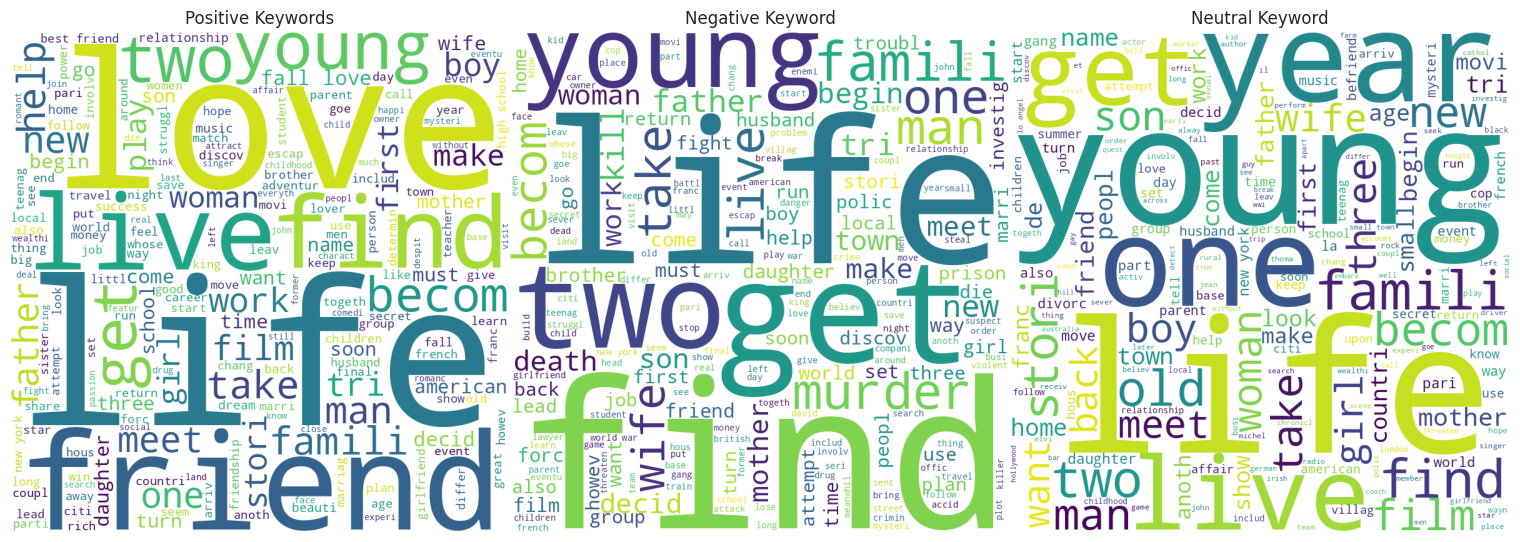

In [ ]:
# On affiche les trois wordclouds
plt.figure(figsize=(15,15), facecolor=None)
plt.subplot(2, 3, 1)
plt.imshow(positive_reviews_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Positive Keywords')

plt.subplot(2, 3, 2)
plt.imshow(negative_reviews_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Negative Keyword')

plt.subplot(2, 3, 3)
plt.imshow(neutral_reviews_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Neutral Keyword')

plt.show()

In [ ]:
# On sépare le jeu de données en jeu d'entrainement et de test
X = df_review['clean_overview']
y = df_review['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# On instancie les modèles
count_vectorizer = CountVectorizer()
tfidf_transformer = TfidfTransformer()

In [ ]:
# On fit_transform sur le jeu d'entrainement
X_train_count = count_vectorizer.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)

In [ ]:
# On transforme le jeu de test
X_test_count = count_vectorizer.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_count)

In [ ]:
# On instancie le modèle
nb = MultinomialNB()

In [ ]:
# On entraine le modèle
nb.fit(X_train_tfidf, y_train)
print("Multinomial model trained successfully.")

Multinomial model trained successfully.


In [ ]:
# Prédictions sur l'ensemble d'entraînement
y_train_pred = nb.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy sur l'ensemble d'entraînement:", train_accuracy)

# Prédictions sur l'ensemble de test
y_test_pred = nb.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy sur l'ensemble de test:", test_accuracy)

Accuracy sur l'ensemble d'entraînement: 0.8729255571360834
Accuracy sur l'ensemble de test: 0.671875


In [ ]:
# On affiche les scores
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

    negative       0.68      0.90      0.78       304
     neutral       0.00      0.00      0.00        50
    positive       0.70      0.54      0.61       209

    accuracy                           0.69       563
   macro avg       0.46      0.48      0.46       563
weighted avg       0.63      0.69      0.65       563



In [ ]:
# On créé une matrice de confusion
confusion = confusion_matrix(y_test, y_test_pred)

<Axes: >

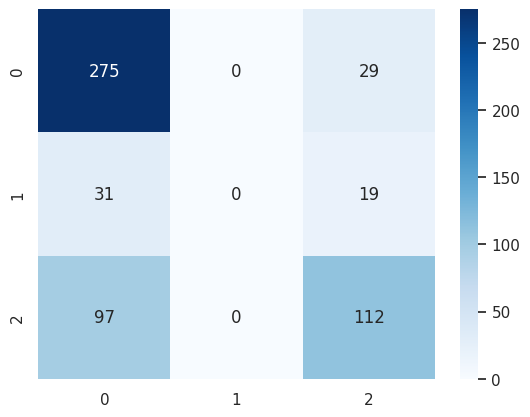

In [ ]:
# On affiche la heatmap
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d')

In [ ]:
# Example new movie
new_movie = ["The kill"]

# Transform the new movie plot
new_movie_vectorized = count_vectorizer.transform(new_movie)

# Predict probability
probabilities = nb.predict_proba(new_movie_vectorized)
print(f"Probability of watching: {probabilities[0][1]:.2f}")

Probability of watching: 0.02


In [ ]:
#Recommedation System(Content Based)

#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a', etc.
tfidf = TfidfVectorizer(stop_words='english')

#Replacing NaN with an empty string
df['overview'] = df['overview'].fillna('')

#Constructing the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(2813, 15843)

In [ ]:
#tfidf_matrix.nonzero()
from sklearn.metrics.pairwise import linear_kernel

#compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)

In [ ]:
#construct a reverse map if indices and mivie titles
indices = pd.Series(df.index, index = df['title']).drop_duplicates()

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [ ]:
get_recommendations('The Kill')

,title
2393,The Two Jakes
347,The Cheap Detective
1724,Deadly Illusion
1378,She Spent So Many Hours Under the Sun Lamps
3001,Watch It
1120,The Tragedy of Richard III
1829,Some Kind of Wonderful
3369,WWE King of the Ring 1994
2790,Vermont Is for Lovers
2178,She Knows Too Much


In [ ]:
#Filling null values with empty string.
filledna=df.fillna('')

In [ ]:
#Cleaning the data - making all the words lower case
def clean_data(x):
        return str.lower(x.replace(" ", ""))

In [ ]:
#Identifying features on which the model is to be filtered.
features=['title','region','Primary Actor','Secondary Actor','overview']
filledna=filledna[features]

In [ ]:
# Clean the given value
for feature in features:
    filledna[feature] = filledna[feature].apply(clean_data)

filledna.head()

,title,region,Primary Actor,Secondary Actor,overview
0,thekill,us,richardjaeckel,henryduval,"setinmacao,thefilmfindsrichardjaeckelcastasatw..."
1,abigailleslieisbackintown,us,marymendum,jenniferjordan,abigaillesliehasbeenawayforyearsbuthasnowretur...
3,au-delàdelapeur,fr,michelbouquet,michelconstantin,frenchmovie
4,thecommonman,us,jeancarmet,pierretornade,"aseverysummer,georgeslajoie,hiswifeginetteandg..."
5,themob,us,marclegault,dorothéeberryman,seasoneddrugsmugglerandthieffrançois“chico”tre...


In [ ]:
# Creates a combined text string from various columns of a row in the DataFrame
def create_soup(x):
    return x['title']+ ' ' + x['region'] + ' ' + x['Primary Actor'] + ' ' +x['Secondary Actor']+' '+ x['overview']

filledna['soup'] = filledna.apply(create_soup, axis=1)

In [ ]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(filledna['soup'])



# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)



# Reset index of our main DataFrame and construct reverse mapping as before
filledna=filledna.reset_index()
indices = pd.Series(filledna.index, index=filledna['title'])


In [ ]:
def get_recommendations_new(title, cosine_sim=cosine_sim):
    title=title.replace(' ','').lower()
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

In [ ]:
get_recommendations_new('The Kill', cosine_sim2)

,title
1,Abigail Leslie Is Back in Town
3,Au-delà de la peur
4,The Common Man
5,The Mob
6,The Gypsy
7,"I, You, He, She"
8,Monty Python and the Holy Grail
9,Mr. Sycamore
10,Killer Cop
11,The Prisoner of Second Avenue


In [ ]:
def get_recommendations_by_actor(df, actor_name, cosine_sim, num_recommendations=10):

    # Filter movies featuring the actor in either 'Primary Actor' or 'Secondary Actor'
    actor_movies = df[(df['Primary Actor'].str.contains(actor_name, case=False)) |
                    (df['Secondary Actor'].str.contains(actor_name, case=False))]

    if actor_movies.empty:
        print(f"No movies found for actor: {actor_name}")
        return []

    # Get indices of movies featuring the actor
    actor_movie_indices = actor_movies.index

    # Calculate average similarity scores for movies featuring the actor
    actor_sim_scores = cosine_sim[actor_movie_indices].mean(axis=0)

    # Sort movies based on similarity scores
    sim_scores = sorted(enumerate(actor_sim_scores), key=lambda x: x[1], reverse=True)

    # Get indices of top recommended movies
    movie_indices = [i[0] for i in sim_scores[1:num_recommendations+1]]

    # Return recommended movie titles
    return df['title'].iloc[movie_indices].tolist()

In [ ]:
# Example usage:
actor_name = "Richard Jaeckel"  # Replace with the desired actor name
recommendations = get_recommendations_by_actor(df, actor_name, cosine_sim2)

if recommendations:
    print(f"Recommendations for movies featuring: {actor_name}")
    for movie in recommendations:
        print(f"- {movie}")
else:
    print("No recommendations found.")

Recommendations for movies featuring: Richard Jaeckel
- Abigail Leslie Is Back in Town
- Au-delà de la peur
- The Common Man
- The Mob
- The Gypsy
- I, You, He, She
- Monty Python and the Holy Grail
- Mr. Sycamore
- Killer Cop
- The Prisoner of Second Avenue


In [ ]:
def get_recommendations_by_keyword(df, keyword, num_recommendations=10):

    # Combine title and overview for feature generation
    df['combined_features'] = (
        df['title'].fillna('') + ' ' + df['overview'].fillna('')
    )

    # Reset indices for proper alignment with cosine similarity matrix
    df = df.reset_index(drop=True)

    # Filter rows that contain the keyword (case-insensitive)
    keyword_df = df[
        df['combined_features'].str.contains(keyword, case=False, na=False)
    ]

    if keyword_df.empty:
        print(f"No movies found with keyword '{keyword}'.")
        return []

    # Create a TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_features'])

    # Calculate cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Get the index of the first movie containing the keyword
    keyword_index = keyword_df.index[0]  # Index now matches the reset DataFrame

    # Get similarity scores for the movie containing the keyword
    sim_scores = list(enumerate(cosine_sim[keyword_index]))

    # Sort movies based on similarity scores (excluding the original movie itself)
    sorted_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations + 1]

    # Extract the recommended movie indices
    recommended_indices = [i[0] for i in sorted_scores]

    # Return the recommended movie titles
    recommended_titles = df.iloc[recommended_indices]['title'].tolist()

    return recommended_titles



In [ ]:
# Test the function
key_word = 'crime'  # Replace with the desired actor name
recommendations = get_recommendations_by_keyword(df_review, keyword=key_word, num_recommendations=10)
if recommendations:
    print(f"Recommendations for key word: {key_word}")
    for movie in recommendations:
        print(f"- {movie}")
else:
    print("No recommendations found.")

Recommendations for key word: crime
- Deadly Illusion
- The Cheap Detective
- The Two Jakes
- Kiss Me, Kill Me
- The Tragedy of Richard III
- WWE King of the Ring 1994
- The Track
- Watch It
- Just Like in the Movies
- She Spent So Many Hours Under the Sun Lamps
